# Self-Supervised Learning

Importing and installing the libraries

In [1]:
!pip install tensorflow-addons
!pip install tensorflow_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 207 kB 9.0 MB/s 
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 13.4 MB 1.2 MB/s 
     |████████████████████████████████| 188 kB 57.5 MB/s 
     |████████████████████████████████| 1.1 MB 28.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=96de43e6ef732ebf43ceb952ea094f8b50a31ae55b94effec782ed6dab3f9a44
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=c55583acbe61b05e5fb447b778598184be01f76f87940ddb0f565f6531ce4f5b
  Stored in directory: /root/.ca

In [2]:
import gc
import os
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import tensorflow_addons as tfa
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_similarity as tfsim
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
tfsim.utils.tf_cap_memory() 
gc.collect()
tf.keras.backend.clear_session()

In [4]:
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.9.2
TensorFlow Similarity 0.16.9


## Dataset Preperation

* Loading the data from tensorflow datasets and creating the train, val, test, and query/index splits.

In [5]:
DATA_PATH = Path("tfsim_contrastive_model")
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

### Load The Raw Data

We are going to load the dataset. This dataset is often used in the self-supervised papers, enabling us to reproduce the published results. 

In [7]:
((x_raw_train, y_raw_train), (x_test, y_test)), ds_info = tfds.load(
    "rock_paper_scissors",
    split=["train", "test"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

x_raw_train=tf.image.resize(x_raw_train, [32,32], preserve_aspect_ratio=True)
x_test=tf.image.resize(x_test, [32,32], preserve_aspect_ratio=True)

### Create Data Splits

* Train: Used for self-supervised pre-training and for training the classifiers.
* Test: Reserved for the classifier evaluation.

However, we are partitioning the train data into the following additional splits:

* Validation: Data used for validation metrics during the pre-training phase. 
* Query and Index: Data used to compute matching metrics. The query data is used to retrieve the nearest indexed examples.

The Query and Index split allows us to track the matching classification performance during training. 



In [8]:
# Compute the indicies for query, index, val, and train splits
query_idxs, index_idxs, val_idxs, train_idxs = [], [], [], []
for cid in range(ds_info.features["label"].num_classes):
    idxs = tf.random.shuffle(tf.where(y_raw_train == cid))
    class_length = len(idxs)
    idxs = tf.reshape(idxs, (-1,))
    query_idxs.extend(idxs[:int(class_length*0.04)])  
    index_idxs.extend(idxs[int(class_length*0.04):int(class_length*0.08)])  
    val_idxs.extend(idxs[int(class_length*0.08):int(class_length*0.1)])  
    train_idxs.extend(idxs[int(class_length*0.1):])  

random.shuffle(query_idxs)
random.shuffle(index_idxs)
random.shuffle(val_idxs)
random.shuffle(train_idxs)

In [9]:
def split_data(idxs: list) -> tuple:
    x, y = [], []
    for idx in idxs:
        x.append(x_raw_train[int(idx)])
        y.append(y_raw_train[int(idx)])
    return tf.convert_to_tensor(np.array(x)), tf.convert_to_tensor(np.array(y))


x_query, y_query = split_data(query_idxs)
x_index, y_index = split_data(index_idxs)
x_val, y_val = split_data(val_idxs)
x_train, y_train = split_data(train_idxs)

In [10]:
print(
    tabulate(
        [
            ["train", x_train.shape, y_train.shape],
            ["val", x_val.shape, y_val.shape],
            ["query", x_query.shape, y_query.shape],
            ["index", x_index.shape, y_index.shape],
            ["test", x_test.shape, y_test.shape],
        ],
        headers=["Examples", "Labels"],
    )
)

       Examples           Labels
-----  -----------------  --------
train  (2268, 32, 32, 3)  (2268,)
val    (51, 32, 32, 3)    (51,)
query  (99, 32, 32, 3)    (99,)
index  (102, 32, 32, 3)   (102,)
test   (372, 32, 32, 3)   (372,)


## Self-Supervised Training Setup

### Selecting the Self-Supervised Algorithm

* SimCLR: Only requires the Backbone and the projector and uses a contrastive cross-entropy loss.
* SimSiam: Requires the Backbone, projector, and predictor and only compares the cosine distance between augmented views from the same example.
* Barlow Twins: Only requires the Backbone and the projector and uses a loss that compares the feature covariance instead of contrasting the views.



In [11]:
ALGORITHM = "simsiam"  # "barlow", "simsiam", "simclr"

### Training Parameter Setup

### Augmented View Configuration

* Self-supervised networks require at least two augmented "views" of each example. The DataSet treats each example in the batch as its own class and then the augment function produces two separate views for each example. 

* TensorFlow Similarity provides several random augmentation functions, and here we combine augmenters from the simCLR module to replicate the augmentations used in simsiam.

In [12]:
IMAGE_SIZE = 32
BATCH_SIZE = 512
PRE_TRAIN_EPOCHS = 100
PRE_TRAIN_STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
VAL_STEPS_PER_EPOCH = 20
DIM = 2048 

if ALGORITHM == "simsiam":
    WEIGHT_DECAY = 5e-4
    INIT_LR = 3e-2 * int(BATCH_SIZE / 256)
    WARMUP_LR = 0.0
    WARMUP_STEPS = 0
    
elif ALGORITHM == "barlow":
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3 
    WARMUP_LR = 0.0
    WARMUP_STEPS = 1000
  
elif ALGORITHM == "simclr":
    WEIGHT_DECAY = 5e-4
    INIT_LR = 1e-3  
    TEMPERATURE = 0.5  # For CIFAR10
    

In [19]:
def img_scaling(image):
    return tf.keras.applications.imagenet_utils.preprocess_input(
        image, 
        data_format=None, 
        mode='torch')


@tf.function
def simsiam_augmenter(image, blur=True, area_range=(0.2, 1.0)):
    
    # random resize and crop
    image = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        image, IMAGE_SIZE, IMAGE_SIZE, area_range=area_range)
    
    # The following transforms expect the data to be [0, 1]
    image /= 255.
    
    # random color jitter
    def jitter_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.color_jitter_rand(
            x,
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.4),
            np.random.uniform(0.0, 0.1),
            "multiplicative",
        )

    image = tfsim.augmenters.augmentation_utils.random_apply.random_apply(jitter_transform, p=0.8, x=image)

    # grayscale
    def grascayle_transform(x):
        return tfsim.augmenters.augmentation_utils.color_jitter.to_grayscale(x)

    image = tfsim.augmenters.augmentation_utils.random_apply.random_apply(grascayle_transform, p=0.2, x=image)

    # blur
    if blur:
        image = tfsim.augmenters.augmentation_utils.blur.random_blur(image, p=0.5)

    # horizontal flip
    image = tf.image.random_flip_left_right(image)
    
    # scaling data back to [0, 255]
    image = image * 255.
    image = tf.clip_by_value(image, 0., 255.)

    return image


@tf.function()
def process(image):
    view1 = simsiam_augmenter(image, blur=False)
    view1 = img_scaling(view1)
    view2 = simsiam_augmenter(image, blur=False)
    view2 = img_scaling(view2)
    return (view1, view2)


train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_data = train_data.repeat()
train_data = train_data.shuffle(1024)
train_data = train_data.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices(x_val)
val_data = val_data.repeat()
val_data = val_data.shuffle(1024)
val_data = val_data.map(process, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

In [20]:
!zip "/content/tfsim_contrastive_model/models"


zip error: Nothing to do! (/content/tfsim_contrastive_model/models.zip)


### Visualize Augmentations

The pairs of augmented views side by side. 

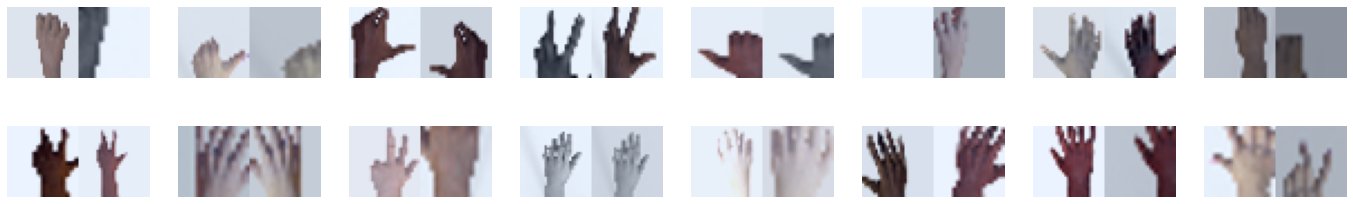

In [21]:
display_images = next(train_data.as_numpy_iterator())
max_pixel = np.max([display_images[0].max(), display_images[1].max()])
min_pixel = np.min([display_images[0].min(), display_images[1].min()])

tfsim.visualization.visualize_views(
    views=display_images,
    num_imgs=16,
    views_per_col=8,
    max_pixel_value=max_pixel,
    min_pixel_value=min_pixel,
)

### Backbone Model

The backbone uses a custom version of ResNet18 in order to reproduce the results.


In [22]:
def get_backbone(image_size, activation="relu", preproc_mode="torch"):
    input_shape = (image_size, image_size, 3)

    backbone = tfsim.architectures.ResNet18Sim(
        input_shape,
        include_top=False,  # Take the pooling layer as the output.
        pooling="avg",
    )
    return backbone


backbone = get_backbone(IMAGE_SIZE)
backbone.summary()

Model: "resnet18sim"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet18 (Functional)       (None, 4, 4, 512)         11182784  
                                                                 
 avg_pool (GlobalAveragePool  (None, 512)              0         
 ing2D)                                                          
                                                                 
Total params: 11,182,784
Trainable params: 11,173,056
Non-trainable params: 9,728
_________________________________________________________________


### Projector Model
 
This MLP is common to all the self-supervised models and is typically a stack of 3 layers of the same size. Having too much capacity in the models can make it difficult for the loss to stabilize and converge.
 



In [23]:
def get_projector(input_dim, dim, activation="relu", num_layers: int = 3):
    inputs = tf.keras.layers.Input((input_dim,), name="projector_input")
    x = inputs

    for i in range(num_layers - 1):
        x = tf.keras.layers.Dense(
            dim,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.LecunUniform(),
            name=f"projector_layer_{i}",
        )(x)
        x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name=f"batch_normalization_{i}")(x)
        x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_{i}")(x)
    x = tf.keras.layers.Dense(
        dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="projector_output",
    )(x)
    x = tf.keras.layers.BatchNormalization(
        epsilon=1.001e-5,
        center=False,  
        scale=False,  
        name=f"batch_normalization_ouput",
    )(x)
    
    o = tfsim.layers.ActivationStdLoggingLayer(name="proj_std")(x)
    projector = tf.keras.Model(inputs, o, name="projector")
    return projector


projector = get_projector(input_dim=backbone.output.shape[-1], dim=DIM, num_layers=2)
projector.summary()

Model: "projector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 projector_input (InputLayer  [(None, 512)]            0         
 )                                                               
                                                                 
 projector_layer_0 (Dense)   (None, 2048)              1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 2048)             0         
 on)                                                             
                                                                 
 projector_output (Dense)    (None, 2048)              4194304   
                                                         

### Predictor model


In [24]:
def get_predictor(input_dim, hidden_dim=512, activation="relu"):
    inputs = tf.keras.layers.Input(shape=(input_dim,), name="predictor_input")
    x = inputs

    x = tf.keras.layers.Dense(
        hidden_dim,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_layer_0",
    )(x)
    x = tf.keras.layers.BatchNormalization(epsilon=1.001e-5, name="batch_normalization_0")(x)
    x = tf.keras.layers.Activation(activation, name=f"{activation}_activation_0")(x)

    x = tf.keras.layers.Dense(
        input_dim,
        kernel_initializer=tf.keras.initializers.LecunUniform(),
        name="predictor_output",
    )(x)
    o = tfsim.layers.ActivationStdLoggingLayer(name="pred_std")(x)
    predictor = tf.keras.Model(inputs, o, name="predictor")
    return predictor


predictor = get_predictor(input_dim=DIM, hidden_dim=512)
predictor.summary()

Model: "predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 predictor_input (InputLayer  [(None, 2048)]           0         
 )                                                               
                                                                 
 predictor_layer_0 (Dense)   (None, 512)               1048576   
                                                                 
 batch_normalization_0 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 relu_activation_0 (Activati  (None, 512)              0         
 on)                                                             
                                                                 
 predictor_output (Dense)    (None, 2048)              1050624   
                                                         

## Self-Supervised Algorithms
 



In [27]:
if ALGORITHM == "simsiam":
    loss = tfsim.losses.SimSiamLoss(projection_type="cosine_distance", name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        predictor=predictor, 
        algorithm=ALGORITHM,
        name=ALGORITHM,
    )
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=INIT_LR,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    wd_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=WEIGHT_DECAY,
        decay_steps=PRE_TRAIN_EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH,
    )
    optimizer = tfa.optimizers.SGDW(learning_rate=lr_decayed_fn, weight_decay=wd_decayed_fn, momentum=0.9)
elif ALGORITHM == "barlow":
    loss = tfsim.losses.Barlow(name=ALGORITHM)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm="barlow",
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
elif ALGORITHM == "simclr":
    loss = tfsim.losses.SimCLRLoss(name=ALGORITHM, temperature=TEMPERATURE)

    contrastive_model = tfsim.models.ContrastiveModel(
        backbone=backbone,
        projector=projector,
        algorithm=ALGORITHM,
    )
    optimizer = tfa.optimizers.LAMB(learning_rate=INIT_LR)
else:
    raise ValueError(f"ALGORITHM is not supported.")

### Compile

In [28]:
contrastive_model.compile(
    optimizer=optimizer,
    loss=loss,
)

### Callbacks to stop the learning



In [29]:
log_dir = DATA_PATH / "models" / "logs" / f"{loss.name}_{time.time()}"
chkpt_dir = DATA_PATH / "models" / "checkpoints" / f"{loss.name}_{time.time()}"


evb = tfsim.callbacks.EvalCallback(
    img_scaling(tf.cast(x_query, tf.float32)),
    y_query,
    img_scaling(tf.cast(x_index, tf.float32)),
    y_index,
    metrics=["binary_accuracy"],
    k=1,
    tb_logdir=log_dir,
)
tbc = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=100,
)
mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpt_dir,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
)

TensorBoard logging enable in tfsim_contrastive_model/models/logs/simsiam_1670885687.138702/index


## Model Training
 
The model training provides a number of metrics.
- loss 

- proj_std and pred_std
- binary_accuracy

In [30]:
history = contrastive_model.fit(
    train_data,
    epochs=PRE_TRAIN_EPOCHS,
    steps_per_epoch=PRE_TRAIN_STEPS_PER_EPOCH,
    validation_data=val_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[evb, tbc, mcp],
)

Epoch 1/100
4/4 [==============================] - 49s 6s/step - loss: 0.9961 - proj_std: 0.0219 - pred_std: 0.0180 - val_loss: 0.9806 - val_proj_std: 0.0047 - val_pred_std: 0.0043 - binary_accuracy: 0.8081
Epoch 2/100
4/4 [==============================] - 19s 6s/step - loss: 0.9756 - proj_std: 0.0218 - pred_std: 0.0179 - val_loss: 0.9543 - val_proj_std: 0.0103 - val_pred_std: 0.0085 - binary_accuracy: 0.7475
Epoch 3/100
4/4 [==============================] - 14s 4s/step - loss: 0.9444 - proj_std: 0.0217 - pred_std: 0.0177 - val_loss: 0.9519 - val_proj_std: 0.0129 - val_pred_std: 0.0102 - binary_accuracy: 0.7879
Epoch 4/100
4/4 [==============================] - 14s 4s/step - loss: 0.9048 - proj_std: 0.0215 - pred_std: 0.0173 - val_loss: 0.9524 - val_proj_std: 0.0143 - val_pred_std: 0.0114 - binary_accuracy: 0.8283
Epoch 5/100
4/4 [==============================] - 14s 4s/step - loss: 0.8619 - proj_std: 0.0212 - pred_std: 0.0168 - val_loss: 0.9428 - val_proj_std: 0.0153 - val_pred_std

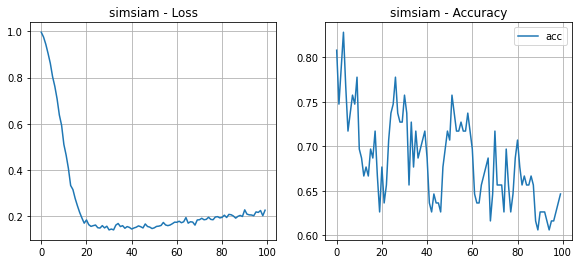

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"])
plt.grid()
plt.title(f"{loss.name} - Loss")

plt.subplot(1, 3, 2)
plt.plot(history.history["binary_accuracy"], label="acc")
plt.grid()
plt.title(f"{loss.name} - Accuracy")
plt.legend()

plt.show()

## Save and Reload

In [33]:
contrastive_model.save(DATA_PATH / "models" / f"trained_model")

[Saving backbone model]
|-path:tfsim_contrastive_model/models/trained_model/backbone


The index was not saved with the model.The model does not currently have an index. To use indexing you must call either model.compile() or model.create_index() and set a valid Distance.
[Saving projector model]
|-path:tfsim_contrastive_model/models/trained_model/projector


[Saving predictor model]
|-path:tfsim_contrastive_model/models/trained_model/predictor


/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [34]:
del contrastive_model

In [35]:
contrastive_model = tfsim.models.contrastive_model.load_model(DATA_PATH / "models" / f"trained_model")

## Evaluation
 
This final section trains two different classifiers.
 
1. No Pre-training: Uses a ResNet18 model and a simple linear layer.
 
2. Pre-trained: Uses the frozen pre-trained backbone from the ContrastiveModel and only trains the weights in the linear layer.


In [36]:
TEST_EPOCHS = 10
TEST_STEPS_PER_EPOCH = int(len(x_train) // BATCH_SIZE)

In [37]:
@tf.function
def eval_augmenter(image):
    # random resize and crop
    image = tfsim.augmenters.augmentation_utils.cropping.crop_and_resize(
        image, IMAGE_SIZE, IMAGE_SIZE, area_range=(0.2, 1.0)
    )
    # random horizontal flip
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image, 0., 255.)

    return image

In [38]:
def get_eval_model(image_size, backbone, total_steps, trainable=True, lr=1.8):
    backbone.trainable = trainable
    inputs = tf.keras.layers.Input((image_size, image_size, 3), name="eval_input")
    x = backbone(inputs, training=trainable)
    o = tf.keras.layers.Dense(3, activation="softmax")(x)
    model = tf.keras.Model(inputs, o)
    cosine_decayed_lr = tf.keras.experimental.CosineDecay(initial_learning_rate=lr, decay_steps=total_steps)
    opt = tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])
    return model

In [39]:
eval_train_data = tf.data.Dataset.from_tensor_slices((x_train, tf.keras.utils.to_categorical(y_train, 3)))
eval_train_data = eval_train_data.repeat()
eval_train_data = eval_train_data.shuffle(1024)
eval_train_data = eval_train_data.map(lambda x, y: (eval_augmenter(x), y), tf.data.AUTOTUNE)
eval_train_data = eval_train_data.map(lambda x, y: (img_scaling(x), y), tf.data.AUTOTUNE)
eval_train_data = eval_train_data.batch(BATCH_SIZE)
eval_train_data = eval_train_data.prefetch(tf.data.AUTOTUNE)

eval_val_data = tf.data.Dataset.from_tensor_slices((x_val, tf.keras.utils.to_categorical(y_val, 3)))
eval_val_data = eval_val_data.repeat()
eval_val_data = eval_val_data.shuffle(1024)
eval_val_data = eval_val_data.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_val_data = eval_val_data.batch(BATCH_SIZE)
eval_val_data = eval_val_data.prefetch(tf.data.AUTOTUNE)

eval_test_data = tf.data.Dataset.from_tensor_slices((x_test, tf.keras.utils.to_categorical(y_test, 3)))
eval_test_data = eval_test_data.map(lambda x, y: (img_scaling(tf.cast(x, dtype=tf.float32)), y), tf.data.AUTOTUNE)
eval_test_data = eval_test_data.batch(BATCH_SIZE)
eval_test_data = eval_test_data.prefetch(tf.data.AUTOTUNE)

### No Pretrain

In [44]:
no_pretrain_eval_model = get_eval_model(
    image_size=IMAGE_SIZE,
    backbone=get_backbone(IMAGE_SIZE, DIM),
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=True,
    lr=1e-3,
)
no_pretrain_history = no_pretrain_eval_model.fit(
    eval_train_data,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
4/4 [==============================] - 12s 2s/step - loss: 1.1840 - acc: 0.3232 - val_loss: 1.1351 - val_acc: 0.3379
Epoch 2/10
4/4 [==============================] - 5s 2s/step - loss: 1.0741 - acc: 0.4146 - val_loss: 1.1497 - val_acc: 0.2887
Epoch 3/10
4/4 [==============================] - 5s 2s/step - loss: 1.0222 - acc: 0.4595 - val_loss: 1.0503 - val_acc: 0.3636
Epoch 4/10
4/4 [==============================] - 5s 2s/step - loss: 0.9610 - acc: 0.5229 - val_loss: 0.9681 - val_acc: 0.5491
Epoch 5/10
4/4 [==============================] - 5s 2s/step - loss: 0.9127 - acc: 0.5854 - val_loss: 0.9015 - val_acc: 0.6055
Epoch 6/10
4/4 [==============================] - 5s 2s/step - loss: 0.8910 - acc: 0.6226 - val_loss: 0.8421 - val_acc: 0.7306
Epoch 7/10
4/4 [==============================] - 5s 2s/step - loss: 0.8418 - acc: 0.6436 - val_loss: 0.8120 - val_acc: 0.7871
Epoch 8/10
4/4 [==============================] - 5s 2s/step - loss: 0.8565 - acc: 0.6230 - val_loss: 0.7938 -

### Pretrained

In [45]:
pretrain_eval_model = get_eval_model(
    image_size=IMAGE_SIZE,
    backbone=contrastive_model.backbone,
    total_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH,
    trainable=False,
    lr=30.0,
)
pretrain_eval_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eval_input (InputLayer)     [(None, 32, 32, 3)]       0         
                                                                 
 resnet18sim (SimilarityMode  (None, 512)              11182784  
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 11,184,323
Trainable params: 1,539
Non-trainable params: 11,182,784
_________________________________________________________________


In [46]:
pretrain_history = pretrain_eval_model.fit(
    eval_train_data,
    batch_size=BATCH_SIZE,
    epochs=TEST_EPOCHS,
    steps_per_epoch=TEST_STEPS_PER_EPOCH,
    validation_data=eval_val_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/10
4/4 [==============================] - 5s 1s/step - loss: 913.2408 - acc: 0.3545 - val_loss: 1647.3418 - val_acc: 0.3328
Epoch 2/10
4/4 [==============================] - 3s 997ms/step - loss: 948.3001 - acc: 0.3394 - val_loss: 1619.3373 - val_acc: 0.3325
Epoch 3/10
4/4 [==============================] - 3s 1s/step - loss: 1202.0626 - acc: 0.3311 - val_loss: 1463.4761 - val_acc: 0.3329
Epoch 4/10
4/4 [==============================] - 3s 1s/step - loss: 1021.9335 - acc: 0.3584 - val_loss: 1009.9676 - val_acc: 0.1963
Epoch 5/10
4/4 [==============================] - 3s 1s/step - loss: 622.0041 - acc: 0.3984 - val_loss: 984.3065 - val_acc: 0.4332
Epoch 6/10
4/4 [==============================] - 3s 1s/step - loss: 684.1860 - acc: 0.3877 - val_loss: 740.0826 - val_acc: 0.3508
Epoch 7/10
4/4 [==============================] - 3s 1s/step - loss: 634.4424 - acc: 0.4307 - val_loss: 713.6334 - val_acc: 0.3527
Epoch 8/10
4/4 [==============================] - 3s 1s/step - loss: 509.3

### Comparison

In [47]:
print(str(ALGORITHM)+": No Pretrain", pretrain_eval_model.evaluate(eval_test_data))
print(str(ALGORITHM)+": Pretrain", no_pretrain_eval_model.evaluate(eval_test_data))

1/1 [==============================] - 1s 1s/step - loss: 445.4172 - acc: 0.3333
simsiam: No Pretrain [445.4172058105469, 0.3333333432674408]
1/1 [==============================] - 0s 147ms/step - loss: 0.8770 - acc: 0.6129
simsiam: Pretrain [0.8769866228103638, 0.6129032373428345]
